In [1]:
import numpy as np
import pandas as pd
# %pip install osmnet
import pandana
# print(pandana.__version__)
import datetime

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import logging

nblog = open("./logs/localness_pandana_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
%%time
df_order = pd.read_csv("./data/Dubai_all_delivery_202310_processed.csv", sep=",", header=0)
print(df_order.shape[0])

2919915
CPU times: user 8.68 s, sys: 6.79 s, total: 15.5 s
Wall time: 46.9 s


In [4]:
# df_customerlocs = df_order[['account_id','customer_lon','customer_lat']]
# df_customerlocs.drop_duplicates(inplace=True)
# print(df_customerlocs.shape[0])
# df_customerlocs.head()

In [5]:
df_vendor = pd.read_csv('./data/all_vendor_oct_processed.csv',header=0)
df_vendor['vendor_index'] = df_vendor.index
print(df_vendor.shape[0])
df_vendor.head()

8105


,vertical,vendor_id,main_cuisine,vendor_name,vendor_lon,vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


# Retrieve OSM driving road network of Dubai by bouding box
only need to run download code once, can load the saved network data in the future

In [9]:
%%time
## Wall time: 5min
from pandana.loaders import osm
network = osm.pdna_network_from_bbox(24.849396, 54.928797, 25.474479, 55.773907, network_type='drive')

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](24.84939600,55.35026070,25.16669327,55.77392514);>;);out;'}"
Downloaded 9,466.5KB from www.overpass-api.de in 2.04 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](24.84939600,54.92879700,25.16257778,55.35443162);>;);out;'}"
Downloaded 29,358.6KB from www.ove

In [10]:
network.nodes_df.to_csv('./output/nodes.csv')
network.edges_df.to_csv('./output/edges.csv')
network.edges_df.head()

from          to   distance
21133789 95063474    21133789  95063474   264.64985 
         642942771   21133789  642942771  95.63152  
21162710 267369795   21162710  267369795  679.96710 
         1014768766  21162710  1014768766 1180.95844
21162918 1014766460  21162918  1014766460 1221.37087

In [11]:
%%time
# load existing network data
nodes = pd.read_csv('./output/nodes.csv', index_col=0)
print(nodes.shape[0])
edges = pd.read_csv('./output/edges.csv', index_col=[0,1])
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

110123
CPU times: user 1min 15s, sys: 4.63 s, total: 1min 20s
Wall time: 14.9 s


# Assign nearest network node_ids to each customer location

In [12]:
%%time
all_nodes = network.get_node_ids(df_order.customer_lon, df_order.customer_lat).values
print(all_nodes.shape[0]) #2919915
df_order['node_id'] = all_nodes
print(df_order.node_id.unique().shape[0])  #87601

2919915
41921
CPU times: user 5.2 s, sys: 903 ms, total: 6.1 s
Wall time: 16.3 s


In [35]:
# %%time
# customer_nodes = network.get_node_ids(df_customerlocs.customer_lon, df_customerlocs.customer_lat).values
# print(customer_nodes.shape[0])
# df_customerlocs['node_id'] = customer_nodes
# df_customerlocs.node_id.unique().shape[0]

# Identify nearest restaurants
https://github.com/UDST/pandana/blob/dev/examples/Pandana-demo.ipynb

In [13]:
df_vendor = df_vendor.rename(columns={"vendor_id": "n_vendor_id","main_cuisine":"n_main_cuisine",'vendor_name':'n_vendor_name',
                                       'vendor_lon':'n_vendor_lon','vendor_lat':'n_vendor_lat','vertical':'n_vertical'})
print(df_vendor.shape[0])
print(df_vendor.n_main_cuisine.unique().shape[0])
df_vendor.head()

8105
66


,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1
2,food,39238,yemeni,"Al Rukn Al Arabi, Al Sawan,Al Rashidiya 3",55.43238,25.39337,2
3,food,714271,seafood,"Not Only Fish, Jumeirah Lakes Towers - JLT",55.14158,25.06848,3
4,food,709554,fast food,"Pasta La Pizza, Bluewaters Island",55.12460,25.07763,4


In [14]:
%%time
# Add different types of restaurants into the network.
max_search_resturants = 1 
max_dist = 50000 # 50km

for cat in df_vendor.n_main_cuisine.unique().tolist():
    df_vendor_onetype = df_vendor[df_vendor['n_main_cuisine']==cat]
    network.set_pois(category = cat,
                     maxdist = max_dist,
                     maxitems = max_search_resturants, # max number of restaurants to search
                     x_col = df_vendor_onetype.n_vendor_lon, 
                     y_col = df_vendor_onetype.n_vendor_lat)

CPU times: user 3.55 s, sys: 678 ms, total: 4.23 s
Wall time: 12 s


In [15]:
df_order.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,node_id
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.00000,2.36000,78.50000,NaN,NaN,249215302.00000,55.22939,25.16458,55.17584,25.10785,18,37,54,1016380490
1,6623723,1304803532,2023-10-10,2023-10-10 01:59:24,680435,Bao,asian,food,4.00000,2.82000,94.00000,True,20.00000,249057659.00000,55.51919,25.23093,55.50995,25.22327,1,5,20,4886488056


In [ ]:
# df_order_onetype = df_order[df_order['main_cuisine']==cat]

In [19]:
%%time
# search the nearest same type of restaurants
import traceback
import os 

output_file = './data/Dubai_all_delivery_202310_processed_nearest.csv'
i = 1
for cat in df_vendor.n_main_cuisine.unique().tolist():
    try:
        print(datetime.datetime.now(), cat, i,'/',df_vendor.n_main_cuisine.unique().shape[0])
        i+=1
        df_nearest_samerest = network.nearest_pois(distance = max_dist,
                                   category = cat,
                                   num_pois = max_search_resturants,
                                   include_poi_ids = True)
        df_nearest_samerest = df_nearest_samerest.reset_index()
        df_nearest_samerest.dropna(inplace=True) # drop nodes without any nearest restaurants within max_dist
        df_nearest_samerest.poi1 = df_nearest_samerest.poi1.astype(int)
        df_nearest_samerest = df_nearest_samerest.rename(columns={"id": "node_id", 1:"nearest_dist1"}) #, "poi1":"vendor_index"

        df_order_onetype = df_order[df_order['main_cuisine']==cat]
        df_order_onetype_mergedist = df_order_onetype.merge(df_nearest_samerest, on='node_id')
        df_order_onetype_mergedist = df_order_onetype_mergedist.merge(df_vendor,left_on='poi1',right_on='vendor_index')

        if not os.path.isfile(output_file):
            df_order_onetype_mergedist.to_csv(output_file,index=False)
        else: # else it exists so append without writing the header
            df_order_onetype_mergedist.to_csv(output_file, mode='a', header=False,index=False)
        
    except Exception:
        traceback.print_exc()
        print(cat)

2024-06-03 16:22:51.675084 coffee 1 / 66
2024-06-03 16:23:02.971974 emirati 2 / 66
2024-06-03 16:23:06.375420 yemeni 3 / 66
2024-06-03 16:23:10.583719 seafood 4 / 66
2024-06-03 16:23:13.809683 fast food 5 / 66
2024-06-03 16:23:55.955145 american 6 / 66
2024-06-03 16:24:03.974622 indian 7 / 66
2024-06-03 16:24:24.793489 dessert 8 / 66
2024-06-03 16:24:39.845118 healthy 9 / 66
2024-06-03 16:24:50.416539 bbq 10 / 66
2024-06-03 16:25:00.352559 arabic 11 / 66
2024-06-03 16:25:20.771364 acai 12 / 66
2024-06-03 16:25:24.432285 european 13 / 66
2024-06-03 16:25:26.407910 african 14 / 66
2024-06-03 16:25:29.219974 international 15 / 66
2024-06-03 16:25:33.957086 asian 16 / 66
2024-06-03 16:25:39.052239 japanese 17 / 66
2024-06-03 16:25:45.046339 lebanese 18 / 66
2024-06-03 16:25:57.297613 italian 19 / 66
2024-06-03 16:26:03.948877 breakfast 20 / 66
2024-06-03 16:26:10.013307 filipino 21 / 66
2024-06-03 16:26:12.676056 chicken 22 / 66
2024-06-03 16:26:15.082122 greek 23 / 66
2024-06-03 16:26:16.

# Compute shortest distance between customer and restaurants actually ordering from

In [20]:
%%time
output_file = './data/Dubai_all_delivery_202310_processed_nearest.csv'
df_localness = pd.read_csv(output_file, sep=",", header=0)
print(df_localness.shape[0])

2916806
CPU times: user 16.2 s, sys: 3.21 s, total: 19.4 s
Wall time: 54.4 s


In [21]:
df_localness['nearest_dist1'] = df_localness['nearest_dist1']/1000  # convert to km

In [22]:
%%time
# First, identify the nearest node to each lon lat coordinate
customer_nodes = network.get_node_ids(df_localness.customer_lon, df_localness.customer_lat).values
vendor_nodes = network.get_node_ids(df_localness.vendor_lon, df_localness.vendor_lat).values
distances_order = network.shortest_path_lengths(vendor_nodes, customer_nodes)
print(len(distances_order))
# df_localness['pandana_distance_realdist'] = distances_order
df_localness['pandana_distance_realdist'] = [x / 1000 for x in distances_order] # convert to km

2916806
CPU times: user 1min, sys: 522 ms, total: 1min
Wall time: 32 s


In [29]:
# len(customer_nodes)

2916806

In [23]:
# %%time
# n_vendor_nodes = G.get_node_ids(df_order.n_vendor_lon, df_order.n_vendor_lat).values
# distances_to_nearest_restaurants = G.shortest_path_lengths(n_vendor_nodes, customer_nodes)
# df_localness['pandana_distance_nearest_dist'] = [x / 1000 for x in distances_to_nearest_restaurants] 

# Localness index

In [24]:
df_localness['pandana_localness'] = df_localness['nearest_dist1']/df_localness['pandana_distance_realdist']

In [25]:
# df_localness['pandana_localness'].hist(bins=40,ec='None')
# df_localness[df_localness['nearest_dist1'] > df_localness['pandana_distance_realdist']+1]

<Axes: >

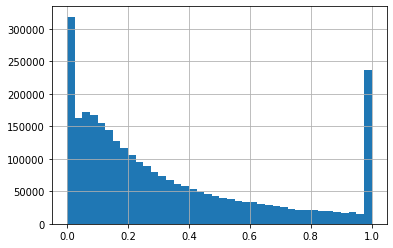

In [3]:
df_localness['pandana_localness'].hist(bins=40,ec='None')

In [2]:
%%time
df_localness = pd.read_csv('./data/food_localness_oct.csv',header=0)

CPU times: user 14.1 s, sys: 3.4 s, total: 17.5 s
Wall time: 49.8 s


In [4]:
# before excluding abnormal values
print(df_localness.shape[0])
df_localness.pandana_distance_realdist.describe()

2916806


count   2916806.00000
mean    134.80899    
std     733.01533    
min     0.00000      
25%     2.54944      
50%     4.91034      
75%     8.40528      
max     4294.96730   
Name: pandana_distance_realdist, dtype: float64

In [5]:
#exclude some extream values
df_localness = df_localness[df_localness['pandana_distance_realdist']<50] # order distance must be less than 50km
df_localness['speed'] = df_localness['pandana_distance_realdist']/(df_localness['total_duration']/60) # order travel speed, km/h
df_localness = df_localness[df_localness['speed']<60] #must be < 60km/h

2828913


In [6]:
# After exclude abnormal values
print(df_localness.shape[0])
df_localness.pandana_distance_realdist.describe()

2828913


count   2828913.00000
mean    5.65595      
std     4.07543      
min     0.00000      
25%     2.47532      
50%     4.75371      
75%     8.00485      
max     46.27318     
Name: pandana_distance_realdist, dtype: float64

In [7]:
# these are orders from nearest restaurants 
print(df_localness[df_localness['pandana_localness']>=1].shape[0])
print(df_localness[df_localness['pandana_localness']>=1].shape[0]/df_localness.shape[0])

110986
0.03923273709725255


In [8]:
df_localness.groupby('main_cuisine').pandana_localness.mean().sort_values(ascending=False)

main_cuisine
specialty store   1.00000
peruvian          1.00000
kuwaiti           1.00000
iraqi             1.00000
spanish           1.00000
latin american    1.00000
french            0.99952
mongolian         0.99422
singaporean       0.98810
tunisian          0.97509
portuguese        0.90133
british           0.88085
gluten free       0.88039
syrian            0.87939
sliders           0.87462
brazilian         0.87336
saudi             0.86350
georgian          0.86062
indonesian        0.85507
nepalese          0.83520
vietnamese        0.78205
mediterranean     0.77690
jordanian         0.77483
european          0.76174
korean            0.76028
soup              0.75230
middle eastern    0.73628
bowls             0.71840
greek             0.71333
moroccan          0.68735
afghani           0.66473
palestinian       0.66123
vegetarian        0.65705
russian           0.64286
uzbek             0.63714
keto              0.62790
chicken           0.61934
african           0.59458

In [9]:
df_localness.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,node_id,nearest_dist1,poi1,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,vendor_index,pandana_distance_realdist,pandana_localness,speed
0,7051337,1305576462,2023-10-10,2023-10-10 15:30:22,50868,"SHAGHF, Jumeirah 3",coffee,food,0.00000,1.73000,57.75000,True,10.00000,249162013.00000,55.21388,25.15585,55.23119,25.18903,15,17,27,7584090309,0.65335,840,food,697762,coffee,"Awaken Cafe, Al Wasl",55.21303,25.15146,840,4.61410,0.14160,10.25355
1,7051337,1313167366,2023-10-16,2023-10-16 16:43:34,50868,"SHAGHF, Jumeirah 3",coffee,food,7.50000,0.90000,26.25000,True,10.00000,250948408.00000,55.21389,25.15572,55.23119,25.18903,16,13,31,7584090309,0.65335,840,food,697762,coffee,"Awaken Cafe, Al Wasl",55.21303,25.15146,840,4.61410,0.14160,8.93051


In [10]:
df_localness.to_csv('./data/food_localness_oct.csv',sep=',',index=False)